# Noise Characterization of Imaging System and Location 

This a simple notebook with some simple calculation to characterize the noise of an imaging system at particular enviorement. The approach to model both would be by a using a set of images on which we will calculate different noise factors such read noise, sky polution noise, etc.

This started around my personal setup which at the moment of writting this consist on an Explorer Scientific 102ED Carbon Fiber tube, an SkyWatcher EQ6-r mount and a un-modified Nikon Z6_2 with Optlong L-Enhanced filter for pseudo narrowband imaging.

This notebook is heavily based on blog entry by chrisvdberge here: https://dslr-astrophotography.com/long-exposures-multiple-shorter-exposures/ and https://www.ucolick.org/~bolte/AY257/s_n.pdf
Other material used:

- https://github.com/zsyOAOA/noise_est_ICCV2015

Dependencies:
- opencv-python https://pypi.org/project/opencv-python/
- scikit-image https://scikit-image.org/
- matplotlib 
- astropi https://www.astropy.org/



## Types Of Noise Considered

Image noise can range from almost imperceptible specks on a digital photograph taken in good light, to optical and radioastronomical images that are almost entirely noise, from which a small amount of information can be derived by sophisticated processing. Such a noise level would be unacceptable in a photograph since it would be impossible even to determine the subject.

There are a few different type of noises and sources of noise in a typical astronomical setup. I would not considered all off them as some are not contributing largely to the image, or cannot be easily modeled and measured by me.


## SNR or Signal To Noise Ratio

The SNR is simply the ratio between Signal and the noise, o signal divided by noise (i.e the power of each). Signal in or modelization of integration signal of N frames would be

$S_{total} = \sum \limits _{j=1} ^N s_{j}*t_{j}$

Where $N$ is number of frames captured, $s_{j}$ is signal per seconds for frame j and $t_{j}$ is exposure time in seconds. 


## Quantization Noise

Ref: https://arxiv.org/ftp/arxiv/papers/1505/1505.03489.pdf
Ref: https://www.allaboutcircuits.com/technical-articles/quantization-nois-amplitude-quantization-error-analog-to-digital-converters/


Quantization noise appearance is inherent in amplitude quantization process. It is generally
presents due to analog data converted into digital data. In this noise model, the signal to noise
ratio (SNR) is limited by minimum and maximum pixel value, $P_{max}$ and $P_{min}$ respectively.

The SNR is given as
$SNR_{q}=20log_{10} (P_{max} - P_{min}) / \sigma_{n} dB$

Where $\sigma_{n}$ = Standard deviation of noise, when input is full amplitude sine wave SNR becomes
$SNR_{q} = 6n + 1.76 dB$ 

Or in power ratio

$SNR_{q} = 10^{(SNR_{dB}/10)} = 10^{((6n + 1.76)/10)}$ 

Where $n$ is number of bits. Quantization noise obeys the uniform distribution. That is why it is
referred as uniform noise. 





In [303]:
n_bits = 14 # This is Analog to Digital size in bits for the Nikon Z6 II
snr_quant = (6*n_bits+1.76) 
print('SNRquantization = ' + str(snr_quant) + ' dB')

SNRquantization = 85.76 dB


So for the Nikon Z6 which has as ADC of 14bits we have a max SNR of 85.76dB, and each bit would increase the resolution by 6.02dB. We won't be incorporating  this factor but it is good to know max theoretical SNR of our system.

## Sources of Noise

Please note that in the following equations we will use the standar deviation $\sigma$ to model each noise type, which is the square root of the variance of the signal. Think of it for example as the randomness of the photon count being received by the sensor. 

$\sigma = \sqrt{E[X^2]-(E[X])^2}$

Where $E[X]$ is the expected value (the average) of random variable $X$.

### Astronomical Object Noise $\sigma_{obj}$

This noise term represents the object noise we are trying to capture. This is a big bad which would account for the signal (photons) traveling through inter-stelar medium, and arriving through the atmosphere to our sensor.

$\sigma_{obj} = \sqrt{S_{total}} = \sqrt{\sum \limits _{j=1} ^N s_{j}*t_{j}}$

$\sigma_{obj}$ is the final noise present on a well calibrated image where we have fully sustracted different sources of noise using darks and bias frames.

### Sky Noise $\sigma_{sky}$

Sky noise refers to the scattering and reflection of photons in the sky background (and heavy smog in my area) which gets captured by the sensor.

$\sigma_{sky} = \sqrt{Sky_{total}} = \sqrt{\sum \limits _{j=1} ^N Sky_{j}*t_{j}}$

This noise builds up in our sensor over time and we normally do not have the means to measure it and substract from the final image. 

### Dark Current Noise $\sigma_{dc}$

Dark Current noise is the thermal noise

$\sigma_{dc} = \sqrt{DC_{total}} = \sqrt{\sum \limits _{j=1} ^N DC_{j}*t_{j}}$

Our dark frames are normally used to reduce this factor in our images.

### Read Noise $\sigma_{r}$

Read noise does not build up over time and only occurs when reading out the values from the sensor itself. This type of noise can be modeles as Shot Noise for the total integration of $N$ images as

$\sigma_{ro} = \sqrt{N}*Rnoise$

Our bias frames are normally used to reduce this factor in our images. For very large number of captures the read noise can become a significant factor. There is always a trade of between many short exposure images or few long exposure images (more on that later).


## SNR total

$SNR = \frac{\sum \limits _{j=1} ^N s_{j}*t_{j}}{\sigma_{obj} + \sigma_{sky} + \sigma_{dc} + \sigma_{ro}} = \frac{S_{total}}{\sigma_{obj} + \sigma_{sky} + \sigma_{dc} + \sigma_{ro}}$


## Few long exposures or many short exposures

As mentioned above, there is a trade of in how long we keep open the shutter, and how many frames we integrate. Some of the smaller factors like read noise or dark current could become significant. Furthermore the may be little benefit in extending to certain point our exposures, specially depending on sky conditions as we won't be adding much signal versus noise. I strongly recomend reading blog entry by chrisvdberge https://dslr-astrophotography.com/long-exposures-multiple-shorter-exposures/.


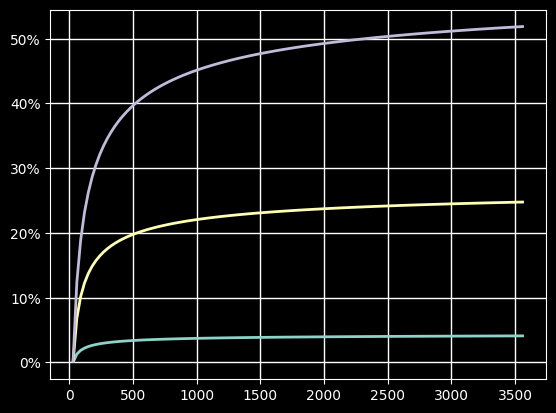

In [304]:
from noise_est_ICCV2015 import noise_estimation
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('dark_background')

def model_sky_noise(time, nframes, sigma):
    return math.sqrt(time*nframes*sigma)

def model_darkcurrent_noise(time, nframes, sigma):
    return math.sqrt(time*nframes*sigma)

def model_read_noise(nframes, sigma):
    return math.sqrt(nframes)*sigma

def snr_vs_exposure(time, nframes, signal, sigma_sky, sigma_dc, sigma_read):
    return signal*nframes*time/(model_sky_noise(nframes, time, sigma_sky)+model_darkcurrent_noise(nframes, time, sigma_dc)+model_read_noise(nframes, sigma_read))

def snr_graph(signal, sigma_sky, sigma_dc, sigma_read, _start=30, _range=3600, _steps=30):
    data = []
    one_30sec_exposure = (snr_vs_exposure(30, _range/30, signal, sigma_sky, sigma_dc, sigma_read))
    #print('one_30sec_exposure' + str(one_30sec_exposure))

    for x in range(_start, _range, _steps):
        value = (snr_vs_exposure(x, _range/x, signal, sigma_sky, sigma_dc, sigma_read))
        data.append(value/one_30sec_exposure*100-100)
        #print('value' + str(value))

    return data

_steps = 3600
plt.plot(range(30, _steps, 30), snr_graph(0.2, 4, 0.0001, 0.5), 
         range(30, _steps, 30), snr_graph(0.2, 0.1, 0.0001, 0.5), 
         range(30, _steps, 30), snr_graph(0.2, 0.02, 0.0001, 0.5))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()